### Project Introduction
- **Goal**: The goal of this project is to create a crossword helper that provides the user additional hints/clues to make solving crosswords more enjoyable. For now, the crossword helper assumes that you have access to the correct answers, but the end product would not require this. Moreover, a separate computer vision piece is being developed so a user can just take a picture of the entire crossword and request help where needed. For now, the crossword will operate on a clue/answer pair as being the input. As far as hint generation goes, the project is heading in a few different directions with varying levels of complexity, which include but are not limited to:
  1. Provide synonyms/related words/antonyms to the answer --> use embeddings/thesaurus
  2. Provide answer classification so the user know what *kind* of word they should be thinking of --> classification problem, probably exists
  3. Provide clue classification so the user knows what *kind* of hint they are looking at --> classification problem
  4. Provide new additional hints so the user can look at an answer from a different perspective --> train a transformer?
- Data: The data used in this project consists of NYT crossword data from 1993-2021.

### Initial Data Inspection, Basic Cleaning

In [5]:
import pandas as pd
import numpy as np
import chardet

with open('nytcrosswords.csv', 'rb') as file:
    result = chardet.detect(file.read())
    print(result['encoding'])  # Displays the detected encoding

df = pd.read_csv('nytcrosswords.csv', encoding=result['encoding'])

ISO-8859-1


In [7]:
### Minimal Cleaning for Deep Learning 
#drop any null rows
df.dropna(inplace=True)

#simple cleaning - get rid of excess whitespace, let BERT handle the rest!
df['Clue'] = df['Clue'].str.strip()
df['Word'] = df['Word'].str.strip()
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')

#Add character count column that shows the length of each answer
df["Character Count"] = df["Word"].apply(len)

#filter to 2021 for smaller dataset
df = df[df['Date'].dt.year == 2021]

#shuffle to reduce bias
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#reset index
df = df.reset_index(drop=True)

#let's add a column that tells you how many characters 
df.info()
df.to_csv('deep_learning_nytcrosswords2021.csv', index = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23420 entries, 0 to 23419
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             23420 non-null  datetime64[ns]
 1   Word             23420 non-null  object        
 2   Clue             23420 non-null  object        
 3   Character Count  23420 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 732.0+ KB


In [8]:
df.head(1)

,Date,Word,Clue,Character Count
0,2021-10-25,STYE,Eyelid affliction,4


### Advanced Data Loading - Batch Processing!

In [ ]:
### Smaller Data Solution - Pandas and Pytorch
import pandas as pd
import chardet
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

# Detect file encoding
with open('nytcrosswords.csv', 'rb') as file:
    result = chardet.detect(file.read())
    encoding = result['encoding']

# Define batch size and chunk size for efficient loading
batch_size = 16
chunk_size = 10000  # Adjust based on memory and performance

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define PyTorch Dataset class
class CrosswordDataset(Dataset):
    def __init__(self, df):
        self.clues = df["Clue"].tolist()
        self.answers = df["Word"].tolist()

    def __len__(self):
        return len(self.clues)

    def __getitem__(self, idx):
        clue = self.clues[idx]
        answer = self.answers[idx]

        # Tokenize clue
        encoding = tokenizer(clue, padding="max_length", truncation=True, return_tensors="pt")

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": answer
        }

# Load CSV in chunks and process data in batches
chunks = pd.read_csv('nytcrosswords.csv', encoding=encoding, chunksize=chunk_size)

for chunk in chunks:
    # Clean and filter data
    chunk.dropna(inplace=True)
    chunk['Clue'] = chunk['Clue'].str.strip()
    chunk['Word'] = chunk['Word'].str.strip()
    chunk['Date'] = pd.to_datetime(chunk['Date'], format='%m/%d/%Y', errors='coerce')
    chunk = chunk[chunk['Date'].dt.year == 2021]

    # Convert to PyTorch dataset and DataLoader
    dataset = CrosswordDataset(chunk)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop (simplified example)
    for batch in dataloader:
        print(batch["input_ids"].shape)  # Check batch shape
        break  # Remove in final implementation


In [ ]:
### Big Data Solution - Apache Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace

# Initialize Spark
spark = SparkSession.builder.appName("CrosswordProcessing").getOrCreate()

# Load large crossword dataset
df_spark = spark.read.csv("crossword_dataset.csv", header=True, inferSchema=True)

# Preprocess: Clean and normalize text in parallel
df_spark = df_spark.withColumn("Clue", lower(col("Clue")))
df_spark = df_spark.withColumn("Clue", regexp_replace(col("Clue"), "[^\w\s]", ""))

# Convert Spark DataFrame to Pandas if needed
df_pandas = df_spark.toPandas()


In [ ]:
### Real Time Crossword Solving: Kafka + Spark Streaming 
from confluent_kafka import Producer

producer = Producer({'bootstrap.servers': 'localhost:9092'})
producer.produce('crossword-clues', key="clue", value="Capital of France")
producer.flush()


In [ ]:
from confluent_kafka import Consumer

consumer = Consumer({'bootstrap.servers': 'localhost:9092', 'group.id': 'clue_solver', 'auto.offset.reset': 'earliest'})
consumer.subscribe(['crossword-clues'])

while True:
    msg = consumer.poll(1.0)  # Wait for new crossword clues
    if msg is None:
        continue
    clue = msg.value().decode("utf-8")
    
    # Solve clue using BERT
    tokens = tokenizer(clue, return_tensors="pt")
    with torch.no_grad():
        output = model(**tokens)
    
    predicted_label = torch.argmax(output.logits, dim=1).item()
    predicted_answer = label_encoder.inverse_transform([predicted_label])
    
    print(f"Clue: {clue} | Predicted Answer: {predicted_answer[0]}")


### Exploring the Full Dataset 
- Questions
    - How often are answered reused? - If answers are reused frequently, then we can reuse clues!
    - Identify trends over the last few decades in NYT crosswords
        - Can use my clue classification algo. to breakdown every crossword
    - **Can I make my own difficulty rating?** 

In [2]:
#Basic Loading and Cleaning Again
import pandas as pd
import chardet

with open('nytcrosswords.csv', 'rb') as file:
    result = chardet.detect(file.read())
    print(result['encoding'])  # Displays the detected encoding

df = pd.read_csv('nytcrosswords.csv', encoding=result['encoding'])

#drop any null rows
df.dropna(inplace=True)

#convert date col to datetimetype 
df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')

#Normalize clues and answers to account for any discrepancies 
import re
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.strip()  # Remove leading/trailing spaces
    return text

df['Clue'] = df['Clue'].apply(clean_text)
df['Word'] = df['Word'].apply(clean_text)

df.info()

ISO-8859-1
<class 'pandas.core.frame.DataFrame'>
Index: 781539 entries, 0 to 781572
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    781539 non-null  datetime64[ns]
 1   Word    781539 non-null  object        
 2   Clue    781539 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 23.9+ MB


In [14]:
#Group by, look for duplicates
#Drop date col for now
df1 = df.iloc[:, 1:3]
df1.info()
#First groupby answer, should default to count 
# Group by 'Answer' by count, sort, and print
df1 = df.groupby('Word').size().reset_index(name='Count')
df1 = df1.sort_values(by='Count', ascending=False)
print(df1.head())

#Do same groupby for clues
df2 = df.groupby('Clue').size().reset_index(name='Count')
df2 = df2.sort_values(by = 'Count', ascending = False)
print(df2.head())

# Group by 'Clue' and count unique answers
clue_group = df.groupby('Clue')['Word'].nunique().reset_index()
clue_group.rename(columns={'Word': 'Unique_Answers'}, inplace=True)
# Sort by number of unique answers
clue_group = clue_group.sort_values(by='Unique_Answers', ascending=False)
# View top results
print(clue_group.head())


<class 'pandas.core.frame.DataFrame'>
Index: 781539 entries, 0 to 781572
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Word    781539 non-null  object
 1   Clue    781539 non-null  object
dtypes: object(2)
memory usage: 17.9+ MB
       Word  Count
17700   era    634
3639   area    534
17728   ere    510
38675   one    510
16684   eli    493
             Clue  Count
0                    176
216623    jai ___    122
260733  mauna ___    113
341628   put away    113
337235    pro ___    106
                Clue  Unique_Answers
0                                109
369084   see 1across              57
369073  see 17across              52
277342          name              41
397407         split              38


There are 296951 duplicate clues which is 38.0% of the total. There are 781539 total clues and 484588 unique clues.
There are 296951 duplicate answers which is 91.9% of the total. There are 781539 and 63310 unique answers. 


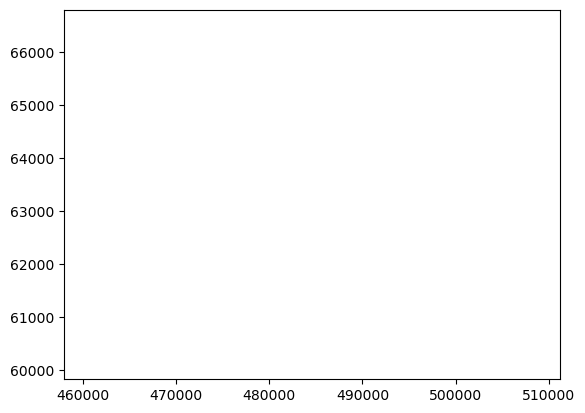

In [89]:
#Naive way to do it 
import numpy as np
import matplotlib.pyplot as plt
clues = df['Clue']
total_clues = len(clues)
uniq_clues = len(set(clues))
diff_clues = total_clues - uniq_clues
prop_clues = np.round( (1 -  (uniq_clues/total_clues)) * 100, 1)
print(f"There are {diff_clues} duplicate clues which is {prop_clues}% of the total. There are {total_clues} total clues and {uniq_clues} unique clues.")

answers = df['Word']
total_answers = len(answers)
uniq_answers = len(set(answers))
diff_answers = total_answers - uniq_answers
prop_answers = np.round((1 - (uniq_answers/total_answers)) * 100, 1)
print(f"There are {diff_clues} duplicate answers which is {prop_answers}% of the total. There are {total_answers} and {uniq_answers} unique answers. ")

plt.plot(uniq_clues, uniq_answers)

### General Approach Thoughts

- Provide various hints
    - Synonym of answer
    - Antonym of answer
    - Help give context to the clue - sentiment analysis, text classification 
    - Help give to context to the answer
        - What kind of word etc.
    - Answer used in sentence
    - Varying level of hints
- How can I incorporate NLP?
- Problem: some answers are multiple words/phrase/proper noun/name
- Later quality of life stuff
    - Autochecker
    - Full puzzle checker
    - Single word checker 

### Classification of Clue Types 
- Goal: classify clue types as definition, wordplay, anagram, name/etc.
- Necessary steps:
    - Create labels for different clue types
    - Train some classification program using labeled data
        - Options: Naive Bayes from DS122, fine tune BERT 

### Other Avenues of Exploration for similar words
- WordNet --> directly pull synonyms, antonyms, related words
- Thesaurus APIs --> fetch related words dynamically
- Context-Aware Model --> pre-trained models like BERT to train a model to predict answers or generate hints based on clue embeddings
    - Use hyperparameter fine tuning
- Real-Time Suggestions -->   leverage APIs to fetch synonyms/related terms in real-time. Probably useful if we haven't seen the answer yet
    - Use GPT APIs for generateing context-aware hint
- Evaluation
    - Try on clues not in the dataset    

### Hint Help 1: Similar Words/Synonyms/Antonyms/Related Words to Answer

- **Goal/Explanation**: 
- **Challenges**: How to handle Answers that are multiple words combined/made up words/names or pronoun/acronym
    - Lots of possible edge cases for Crossword Answers:
        - Multi-woerd answers --> lematize each word separately, rejoin them
        - Made-up words/slang --> use original word if not recognized
        - Proper nouns --> detect named entities, keep same
        - Acronyms --> try to identify ...
        - Foreign words --> keep unchanged
        - Hyphenated words - keep if word exists
        - Contractions --> expand/keep original
        - Numbers in words --> keep 
- **Process**:
- **Areas of improvement**
    - Find more explicit ways to handle the edge cases, ie. use a super long list of common acronyms/slang etc. 

In [3]:
#Load in cleaned data
import pandas as pd
import numpy as np
df = pd.read_csv('deep_learning_nytcrosswords2021.csv')
df.info()

#for now just pick small subset of data, since this section doesn't really require training 
df = df.sample(n=100)
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23420 entries, 0 to 23419
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             23420 non-null  object
 1   Word             23420 non-null  object
 2   Clue             23420 non-null  object
 3   Character Count  23420 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 732.0+ KB


,Date,Word,Clue,Character Count
8609,2021-04-22,SHEBA,"Yemen, in the Bible",5
22811,2021-08-01,ICEE,"Brain freeze cause, maybe",4
22315,2021-09-30,VIDEO,Watch it!,5
9024,2021-10-08,TROT,Moderate pace,4
888,2021-04-21,ONS,Switch positions,3


In [4]:
#Additional preprocessing: more cleaning + lemmatization (reduce words to base/root form)
import re #regular expression to remove undesired characters
import spacy
import nltk
from nltk.corpus import wordnet
nlp = spacy.load("en_core_web_sm") #spaCy English model for lemmatization + named entity recognition

def is_acronym(word):
    """
    Identifies if a word is an acronym or abbreviation based on:
    - Short uppercase words (2-5 characters, no vowels in the middle) (e.g., "FBI", "CIA")
    - Contains numbers (e.g., "G7", "3D")
    - Hyphenated uppercase words (e.g., "X-RAY", "T-SHIRT")
    - CamelCase words (e.g., "iPhone", "eBay")
    - Named Entity Recognition (NER) detects organizations (e.g., "NASA", "FBI")
    """
    word = word.strip()  # Remove extra spaces

    # Short uppercase words (2-5 characters, minimal vowels) are likely acronyms
    if len(word) <= 5 and not re.search(r'[aeiou]', word[1:].lower()):
        return True  

    # Allow hyphenated acronyms (X-RAY, T-SHIRT)
    if "-" in word and all([w.isupper() for w in word.split("-")]):
        return True  

    # Numeric acronyms (3D, B2B)
    if re.search(r'\d', word):
        return True  

    # Check CamelCase words (e.g., iPhone, eBay)
    if re.search(r'^[a-z]+[A-Z]', word):
        return True  

    # Named Entity Recognition (ORG, GPE detection)
    doc = nlp(word)
    if doc[0].ent_type_ in ["ORG", "GPE"]:
        return True  

    return False  # Otherwise, assume it's a normal word

def clean_answers(text):
    """
    Cleans and lemmatizes crossword answers while handling all major edge cases:
    - Keeps acronyms & abbreviations (e.g., "NASA", "FBI", "G7") unchanged
    - Preserves proper nouns (e.g., "EINSTEIN", "BOSTON")
    - Lemmatizes multi-word answers correctly
    - Keeps made-up words/slang unchanged if lemmatization fails
    - Maintains hyphenated words (e.g., "SELF-MADE", "X-RAY")
    - Prevents foreign words from being altered incorrectly
    """
    if not isinstance(text, str) or text.strip() == "":
        return text  # Return as-is if empty or not a string (avoids errors)

    text = text.strip()  # Remove spaces
    text = re.sub(r"[^\w\s\-’']", '', text)  # Remove punctuation except hyphens & apostrophes

    doc = nlp(text)  # Tokenize & process with spaCy
    
    processed_words = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue  # Skip stop words and punctuation
        
        # Keep acronyms, numbers, and uppercase abbreviations unchanged
        if is_acronym(token.text) or token.is_digit:
            processed_words.append(token.text)  # Keep as-is
        elif token.ent_type_ in ["PERSON", "GPE", "ORG"]:  # Named Entities (Proper Nouns)
            processed_words.append(token.text)  # Keep proper nouns as-is
        else:
            lemma = token.lemma_
            processed_words.append(lemma if lemma != token.text else token.text)  # Use lemma if changed
    
    return " ".join(processed_words)  # Do NOT convert everything to uppercase, keep original format

# Create a new column for processed answers without modifying the original column
df['Processed_Word'] = df['Word'].apply(clean_answers)

# Display the first few rows
print(df[['Word', 'Processed_Word']].head())
#takes 3 minutes

        Word Processed_Word
8609   SHEBA          SHEBA
22811   ICEE           ICEE
22315  VIDEO          video
9024    TROT           TROT
888      ONS            ONS


In [5]:
#Now we perform answer classification BEFORE embeddings so that we can more accurately determine similar words
#Categorize answers into bins: 

# Define a list of words that spaCy frequently misclassifies as ORG
FALSE_ORGS = {"HAHAHA", "SLY", "AMMO", "OWE", "UNDEROATH", "AXL"}

def is_acronym(word):
    """Returns True if the word is an acronym."""
    return word.isupper() and len(word) <= 5  # Consider short uppercase words as acronyms

def is_common_noun(word):
    """Check if a word is a common noun using WordNet."""
    synsets = wordnet.synsets(word.lower())
    return any(s.pos() == 'n' for s in synsets)  # If it's a noun in WordNet, return True

def classify_word_type(word):
    """Classifies words using spaCy's built-in NER & POS tagging with additional post-processing."""
    if not isinstance(word, str) or word.strip() == "":  # Handle empty or non-string values
        return "UNKNOWN"

    doc = nlp(word.strip())
    if not doc:  # Handle cases where spaCy fails to parse
        return "UNKNOWN"

    token = doc[0]

    # Named Entities (Prebuilt in spaCy)
    if token.ent_type_ in ["ORG"]:
        # Check if the word passes all the ORG checks
        if word not in FALSE_ORGS and len(word) >= 5 and (is_acronym(word) or not word.islower()) and not is_common_noun(word):
            return "ORGANIZATION"  # Only return "ORGANIZATION" if all checks pass
    elif token.ent_type_ in ["PERSON"]:
        return "PERSON"
    elif token.ent_type_ in ["GPE", "LOC"]:  # **Combining GPE + LOC**
        return "LOCATION"
    
    elif token.ent_type_ in ["EVENT"]:
        return "EVENT"
    elif token.ent_type_ in ["WORK_OF_ART"]:
        return "WORK_OF_ART"
    elif token.ent_type_ in ["PRODUCT"]:
        return "PRODUCT"
    elif token.ent_type_ in ["DATE"]:
        return "DATE"
    elif token.ent_type_ in ["MONEY"]:
        return "MONEY"

    # Parts of Speech (Prebuilt in spaCy)
    if token.pos_ == "VERB":
        return "VERB"
    elif token.pos_ == "NOUN":
        return "NOUN"
    elif token.pos_ == "ADJ":
        return "ADJECTIVE"
    elif token.pos_ == "ADV":
        return "ADVERB"

    return "UNKNOWN"  # Default category for unknown types

In [30]:
#Extra check for multiple words using set of known words/dictionary
import nltk
from nltk.corpus import words

# Set of common English words (from nltk corpus)
word_set = set(words.words())

def is_multi_word(answer):
    # We will now split the word at multiple positions and check if the parts are valid words
    # Split the word into multiple parts and check against the dictionary
    for i in range(1, len(answer)):
        word1 = answer[:i]  # First part
        word2 = answer[i:]  # Second part
        
        if word1 in word_set and word2 in word_set:
            return True  # Valid split into two words
    
    # Try splitting into three parts
    for i in range(1, len(answer)):
        word1 = answer[:i]
        for j in range(i+1, len(answer)):
            word2 = answer[i:j]
            word3 = answer[j:]
            if word1 in word_set and word2 in word_set and word3 in word_set:
                return True  # Valid split into three words

    return False  # If no valid splits found, return False (single word)

# Example usage
print(is_multi_word('goback'))     # Expected output: True (split into "go" and "back")
print(is_multi_word('draw'))       # Expected output: False (Single word)
print(is_multi_word('art'))        # Expected output: False (Single word)
print(is_multi_word('PlayGround')) # Expected output: True (split into "Play" and "Ground")
print(is_multi_word('goahead'))    # Expected output: True (split into "go" and "ahead")
print(is_multi_word('someotherword'))  # Expected output: False (Single word)
print(is_multi_word('kickstartnew')) # Expected output: True (split into "kick", "start", and "new")





True
True
True
False
True
True
True


In [6]:
#Extra check for multiple words using tokenization
def is_multi_word(answer):
    # Tokenize the answer
    doc = nlp(answer)
    # Return True if the number of tokens (words) is greater than 1
    return len(doc) > 1


# Apply the function to check if the word is multi-word and create a new column
df['is_multi_word'] = df['Word'].apply(is_multi_word)

#Apply to cleaned/processed answer
df["Word_Type"] = df["Processed_Word"].apply(classify_word_type)

In [12]:
x = is_multi_word('goback')
x

False

In [20]:
#Use word2vec model (google word dict. to convert words to vectors) to identify most similar words
import gensim.downloader as api

# Load the pretrained model
wv = api.load('word2vec-google-news-300')
print('model loaded')

model loaded


In [21]:
#Now we use embeddings to find similar words - however to make sure these words are actually unique and somewhat match the types
def lemmatize_word(word):
    """Helper function that returns root of word"""
    doc = nlp(word)
    return doc[0].lemma_

def detect_named_entity_type(word):
    """Helper function that detects the type of named entity (e.g., PERSON, GPE, ORG)"""
    doc = nlp(word)
    return doc[0].ent_type_ if doc[0].ent_type_ in ["PERSON", "GPE", "ORG"] else None

def is_valid_word(word, answer_entity_type, answer_is_multi_word):
    """
    Filters words based on context:
    - Allows named entities only if the answer is also a named entity and matches type.
    - Ensures that locations (GPE) return only other locations.
    - Allows multi-word hints if the answer is multi-word.
    - Prevents random garbage words from appearing.
    """
    if "_" in word or " " in word:  # Allow multi-word hints only if answer is multi-word
        return answer_is_multi_word
    if re.search(r"\d", word):  # Remove words containing numbers
        return False

    word_entity_type = detect_named_entity_type(word)

    # If the answer is a GPE (location), ensure only locations appear
    if answer_entity_type == "GPE" and word_entity_type != "GPE":
        return False  # Remove non-location words when the answer is a location

    # Only keep named entities that match the answer type
    if word_entity_type and word_entity_type != answer_entity_type:
        return False  # Remove mismatched named entities

    # If the answer is a named entity, prefer similar proper nouns
    if answer_entity_type and not word_entity_type:
        return False  # Remove non-entities when answer is an entity

    return True

def get_word2vec_similar_words(answer, top_n=5):
    """
    Returns the top-N most similar words using Word2Vec embeddings.
    - Handles named entities separately.
    - Supports multi-word answers by averaging embeddings.
    - Ensures all returned words have unique lemmas.
    """
    answer = answer.lower()
    lemma_answer = lemmatize_word(answer)  # Get root form of the answer
    answer_entity_type = detect_named_entity_type(answer)  # Identify entity type (PERSON, GPE, ORG)
    answer_is_multi_word = " " in answer or "_" in answer  # Check if answer is multi-word
    words = answer.split()  # Split for multi-word handling

    # Check if the full answer exists in Word2Vec
    if answer in wv:
        similar_words = wv.most_similar(answer, topn=top_n * 5)  # Get extra words in case of filtering
    else:
        # Handle multi-word phrases by averaging word embeddings
        vectors = [wv[word] for word in words if word in wv]
        if not vectors:
            return []  # No valid words found

        avg_vector = np.mean(vectors, axis=0)  # Compute mean embedding
        similar_words = wv.similar_by_vector(avg_vector, topn=top_n * 5)

    similar_words = [w[0] for w in similar_words]  # Extract words only

    # Filter out garbage results and near-duplicates
    cleaned_words = set()
    final_words = []
    seen_lemmas = set()  # Track lemmatized versions of words

    for w in similar_words:
        lemma_w = lemmatize_word(w)
        if (
            lemma_w != lemma_answer and answer not in w and lemma_answer not in w
            and is_valid_word(w, answer_entity_type, answer_is_multi_word)
        ):
            if lemma_w not in seen_lemmas:  # Ensure unique lemmas
                seen_lemmas.add(lemma_w)
                cleaned_words.add(w)  # Keep original word, not just the lemma
                final_words.append(w)

    return final_words[:top_n]  # Return only the top-N valid words

# Example Test Cases
print(f"Similar words to 'running': {get_word2vec_similar_words('running')}")
print(f"Similar words to 'Einstein': {get_word2vec_similar_words('Einstein')}")
print(f"Similar words to 'New York': {get_word2vec_similar_words('New York')}")
print(f"Similar words to 'jumping': {get_word2vec_similar_words('jumping')}")
print(f"Similar words to 'fast': {get_word2vec_similar_words('fast')}")
print(f"Similar words to 'beautiful': {get_word2vec_similar_words('beautiful')}")
print(f"Similar words to 'Shakespeare': {get_word2vec_similar_words('Shakespeare')}")
print(f"Similar words to 'Einstein': {get_word2vec_similar_words('Einstein')}")
print(f"Similar words to 'Beethoven': {get_word2vec_similar_words('Beethoven')}")
print(f"Similar words to 'Paris': {get_word2vec_similar_words('Paris')}")
print(f"Similar words to 'New York': {get_word2vec_similar_words('New York')}")
print(f"Similar words to 'Tokyo': {get_word2vec_similar_words('Tokyo')}")
print(f"Similar words to 'Mount Everest': {get_word2vec_similar_words('Mount Everest')}")
print(f"Similar words to 'San Francisco': {get_word2vec_similar_words('San Francisco')}")
print(f"Similar words to 'Harry Potter': {get_word2vec_similar_words('Harry Potter')}")
print(f"Similar words to 'quantum': {get_word2vec_similar_words('quantum')}")
print(f"Similar words to 'alchemy': {get_word2vec_similar_words('alchemy')}")
print(f"Similar words to 'mythology': {get_word2vec_similar_words('mythology')}")


Similar words to 'running': ['rushing', 'sprinting', 'coming', 'switching']
Similar words to 'Einstein': ['albert', 'corey', "o'brien", 'kristin']
Similar words to 'New York': ['amy_zimmer_metro', 'brooklyn', 'patrick_arden_metro', 'los_angeles', 'denver']
Similar words to 'jumping': ['leaping', 'climbing', 'leapt', 'hopping', 'bouncing']
Similar words to 'fast': ['quick', 'rapidly', 'quickly', 'slow', 'rapid']
Similar words to 'beautiful': ['gorgeous', 'lovely', 'wonderful', 'fabulous', 'loveliest']
Similar words to 'Shakespeare': ['www.angelfire.com', 'home.htm', 'theatre.com', 'arts.org', 'nps.gov']
Similar words to 'Einstein': ['albert', 'corey', "o'brien", 'kristin']
Similar words to 'Beethoven': []
Similar words to 'Paris': ['london', 'france', 'dubai', 'hilton', 'rome']
Similar words to 'New York': ['amy_zimmer_metro', 'brooklyn', 'patrick_arden_metro', 'los_angeles', 'denver']
Similar words to 'Tokyo': ['seoul', 'japan', 'toronto', 'washington', 'manhattan']
Similar words to 'M

### Hint Help 3: Classification of Clue Types

In [ ]:
#Classification of Clue Types 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Create labels for clue types (e.g., 0 = definition, 1 = anagram)
df['ClueType'] = ...  # Add this column based on manual labeling

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['Clue'], df['ClueType'], test_size=0.2)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a classifier
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)

# Predict clue types
y_pred = classifier.predict(X_test_tfidf)


In [ ]:
#Recall word vectors pointing in same direction are most similar
#wv.most_similar('____')

#Helper function to identify similarity between words, 1 = synonym, -1 = antonym, 0 = none
def find_cosine(vec1, vec2):
  # Scale vectors to both have unit length
  unit_vec1 = vec1/np.linalg.norm(vec1)
  unit_vec2 = vec2/np.linalg.norm(vec2)
  # The dot product of unit vectors gives the cosine of their angle
  return np.dot(unit_vec1,unit_vec2)

#Getting sentence level vectors
    #Naive approach - avg meaning vector 
    #more advanced - neural network with embedding 

### Hint Help 4: Fine tune transformer (BERT) to give hints

In [3]:
#import data
import pandas as pd
import numpy as np 
df = pd.read_csv('deep_learning_nytcrosswords2021.csv')

In [4]:
df.head(5)

,Date,Word,Clue
0,2021-10-25,STYE,Eyelid affliction
1,2021-01-27,FUNK,"""I only got a seventh-grade education, but I h..."
2,2021-08-12,COCOA,Warmer in the winter
3,2021-10-26,CHEF,___ Boyardee
4,2021-08-08,SEEDIER,More like a dive bar or certain bread


In [8]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return False (CUDA is for NVIDIA)
print(torch.backends.mps.is_available())  # Check if Metal is available (Mac users)
print(torch.cuda.device_count())  # Should show 1+ if using ROCm


2.5.1+cpu
False
False
0


In [10]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
print("BERT is ready to use!")


BERT is ready to use!


In [13]:
# Count unique answers dynamically
num_unique_answers = df["Word"].nunique()
print(f"Number of unique answers: {num_unique_answers}")


Number of unique answers: 13193


In [16]:
from transformers import BertTokenizer, BertForSequenceClassification

#using uncased model for speed and performacne 
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_unique_answers)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Tokenize the clues
tokens = tokenizer(df["Clue"].tolist(), padding=True, truncation=True, return_tensors="pt")

# Convert answers to numerical labels (assuming we have 5000 unique answers)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df["Word"])  # Converts text answers to numbers


In [19]:
import torch
from torch.utils.data import Dataset, DataLoader

class CrosswordDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.tokens.items()}
        item["labels"] = self.labels[idx]
        return item

# Create dataset and DataLoader
dataset = CrosswordDataset(tokens, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [21]:
#Check if it worked so far:
# Get the first item from the dataset
first_sample = dataset[0]  # This should return a dictionary

# Print the keys in the sample
print(first_sample.keys())

# Print the actual contents of the sample
print("Input IDs:", first_sample["input_ids"])
print("Attention Mask:", first_sample["attention_mask"])
print("Label:", first_sample["labels"])

print("Decoded Clue:", tokenizer.decode(first_sample["input_ids"]))


dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Input IDs: tensor([  101,  3239, 21273, 21358, 29301,  3258,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor(11338)
Decoded Clue: [CLS] eyelid affliction [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# 📌 Fine-Tuning BERT for Crossword Solving

## **1️⃣ Conceptual Overview**
Fine-tuning BERT means **adapting a pre-trained language model** to specialize in **solving crossword clues**. Instead of training BERT from scratch, we **modify its last layers** so that it learns to map **crossword clues to correct answers**.

🔹 **What we’re doing:**  
- Giving BERT **crossword clues** as input.  
- Training it to **predict the correct answer** (classification task).  
- Using **supervised learning** (training with labeled crossword data).  
- Adjusting BERT’s weights so it learns **patterns in crossword clues** over multiple epochs.

---

## **2️⃣ Technical Breakdown**
### **1️⃣ Loading Pre-trained BERT Model**
- We use `bert-base-uncased`, a pre-trained **Transformer model** that already understands English.  
- Modify BERT’s **final layer** to classify one of many possible crossword answers.

### **2️⃣ Tokenizing Data**
- Convert crossword clues into **tokenized input** that BERT can understand.  
- Convert answers into **numerical labels** using `LabelEncoder()`.

### **3️⃣ Training Process (Fine-Tuning)**
The fine-tuning process consists of:
1. **Forward Pass:** BERT takes a **tokenized crossword clue** and predicts an answer.  
2. **Loss Calculation:** Compare BERT’s predicted answer to the correct answer using **CrossEntropyLoss**.  
3. **Backpropagation:** Compute gradients to understand **how much each weight contributed to the error**.  
4. **Optimizer Update:** Adjust BERT’s weights using **Adam optimizer- Common optimization algo in DL. * to improve predictions.  
5. **Repeat for Multiple Epochs:** The model gradually gets better at predicting correct answers.  

---

## **3️⃣ Key Code Components**
```python
optimizer = Adam(model.parameters(), lr=2e-5)  # Adjust BERT’s weights
loss_fn = torch.nn.CrossEntropyLoss()  # Measure how far off the predictions are

for epoch in range(epochs):
    for batch in dataloader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(**inputs)  # Forward pass: Predict crossword answer
        loss = loss_fn(outputs.logits, labels)  # Calculate loss
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model weights


In [ ]:
from transformers import AdamW
from torch.optim import Adam

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and loss function
optimizer = Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3  # Adjust as needed
for epoch in range(epochs):
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()

        # Move batch to GPU if available
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(**inputs)
        loss = loss_fn(outputs.logits, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23420 entries, 0 to 23419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    23420 non-null  datetime64[ns]
 1   Word    23420 non-null  object        
 2   Clue    23420 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 549.0+ KB


### Crossword Inputs Section
- Option 1: manually type in hint and the answer --> not a very good option since you have to see the answer but simple enough
- Option 2: manually type in just the clue, spaces used --> more realistic scenario but helper has to come up with the answer.
- Option 3: use computer vision to scan the crossword clues and the crossword answers.
    - Easiest/best/fastest solution, but requires user to have an answer key and also to look at it.
- Option 4: use computer vision to scan empty crossword with hints. Helper has to come up with the answers on its own.
    - Probably the most practical for a normal person doing a newspaper crossword without access to answers.
    - So this is the ideal end goal.


In [ ]:
#Option 1:
